In [8]:
import sleap_io as sio
from torch.utils.data import Dataset
import kornia as K
from kornia.augmentation import AugmentationBase2D
from typing import List
import matplotlib.pyplot as plt
import torch 
from kornia.augmentation.container import AugmentationSequential

# Testing Kornia

In [2]:

class SleapDataset(Dataset):
    """Dataset for loading items from Labels object."""

    def __init__(
        self,
        labels: sio.Labels,
        transforms: List[AugmentationBase2D] = None
    ):
        """Initialize SleapDataset.

        Args:
            labels: sleap_io.Labels object that contains LabeledFrames
        """
        # super().__init__()
        self.labels = labels
        self.data = []
        self.transforms = transforms

        # Store data in self.data -> format [(LabeledFrame index, Instance index),
        #     (LabeledFrame index, Next Instance index)...]

        for lf_idx, lf in enumerate(labels):
            inst_amt = len(lf.instances)
            self.data.extend([(lf_idx, inst_idx) for inst_idx in range(inst_amt)])

        # Define object augmentations

    def __len__(self):
        """Return the number of instances available."""
        return len(self.data)

    def __getitem__(self, index: int):
        """Return a single item corresponding to a single instance in a single frame."""
        lf_idx, inst_idx = self.data[index]
        lf = self.labels[lf_idx]
        inst = lf[inst_idx]
        img = lf.image  # must be permuted

        # Modularized augmentations.
        if self.transforms:
            img, kp = self.transforms(img, inst.numpy())
        else:
            kp = inst.numpy()

        return img, kp, cm

In [3]:
l = sio.load_slp("../../tests/data/minimal_instance.pkg.slp")
dataset = SleapDataset(l)

In [31]:
l = sio.load_slp("labels.slp")
dataset = SleapDataset(l)

i = 1

augmentation_pipeline = AugmentationSequential(
    # K.augmentation.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1), scale=(0.8, 1.2)),
    # K.augmentation.ColorJitter(0.2, 0.2, 0.2, 0.2),
    # K.augmentation.RandomHorizontalFlip(p=0.5),
    # K.augmentation.RandomVerticalFlip(p=0.5),
    K.augmentation.RandomRotation(degrees=90, p=1.0),
    data_keys=["input", "keypoints"]
)

img_ = K.color.grayscale_to_rgb(torch.Tensor(dataset[i][2]).permute(2, 0, 1))
augmented_image, augmented_keypoints = augmentation_pipeline(img_, torch.Tensor(dataset[i][1].numpy()))

kp = dataset[i][1].numpy()


In [32]:
img_.shape, augmented_image.shape, kp.shape, augmented_keypoints.shape

(torch.Size([3, 1024, 1024]),
 torch.Size([1, 3, 1024, 1024]),
 (13, 2),
 torch.Size([13, 2]))

In [33]:
kp

array([[507.98461552, 256.12307694],
       [539.49230776, 269.6153847 ],
       [565.46923104, 280.9615388 ],
       [581.10769246, 295.6153847 ],
       [585.23846164, 284.86153858],
       [         nan,          nan],
       [509.60000022, 243.52307672],
       [509.86153858, 297.49230776],
       [546.83846186, 226.7692306 ],
       [548.98461552, 305.74615388],
       [574.72307716, 266.98461552],
       [511.36923082, 269.86153858],
       [519.6153847 , 249.73846164]])

In [45]:
import numpy as np
np.nanmax(kp, axis=0)

array([585.23846164, 305.74615388])

In [34]:
augmented_keypoints

tensor([[367.2333, 300.7469],
        [400.9428, 294.5464],
        [428.8581, 289.6195],
        [449.9932, 293.1693],
        [447.4819, 281.9264],
        [     nan,      nan],
        [361.6052, 289.3586],
        [391.6924, 334.1638],
        [383.3480, 254.7950],
        [428.8454, 319.3856],
        [428.8298, 272.8568],
        [377.6558, 310.3162],
        [373.3868, 288.9923]])

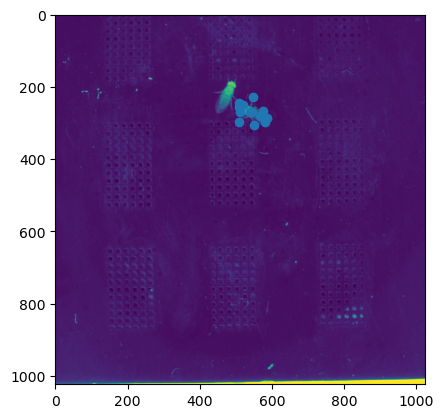

In [35]:
plt.imshow(dataset[i][2])
plt.scatter(kp[:, 0], kp[:, 1])


In [42]:
dataset[i][2].shape

(1024, 1024, 1)

In [52]:
dataset[i][1].numpy()

array([[507.98461552, 256.12307694],
       [539.49230776, 269.6153847 ],
       [565.46923104, 280.9615388 ],
       [581.10769246, 295.6153847 ],
       [585.23846164, 284.86153858],
       [         nan,          nan],
       [509.60000022, 243.52307672],
       [509.86153858, 297.49230776],
       [546.83846186, 226.7692306 ],
       [548.98461552, 305.74615388],
       [574.72307716, 266.98461552],
       [511.36923082, 269.86153858],
       [519.6153847 , 249.73846164]])

In [78]:
import albumentations as A

c = A.Compose([
    A.Crop(506, 225, 586, 306)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

kp = np.nan_to_num(dataset[i][1].numpy(), nan=0)
img_kp = c(image=dataset[i][2], keypoints=kp)
img = img_kp["image"]
kp_ = img_kp["keypoints"]

In [79]:
kp.shape

(13, 2)

In [80]:
kp

array([[507.98461552, 256.12307694],
       [539.49230776, 269.6153847 ],
       [565.46923104, 280.9615388 ],
       [581.10769246, 295.6153847 ],
       [585.23846164, 284.86153858],
       [  0.        ,   0.        ],
       [509.60000022, 243.52307672],
       [509.86153858, 297.49230776],
       [546.83846186, 226.7692306 ],
       [548.98461552, 305.74615388],
       [574.72307716, 266.98461552],
       [511.36923082, 269.86153858],
       [519.6153847 , 249.73846164]])

In [81]:
np.array(kp_).shape

(13, 2)

In [82]:
kp_ = np.array(kp_)

kp_[5, :] = np.nan

kp_

array([[ 1.98461552, 31.12307694],
       [33.49230776, 44.6153847 ],
       [59.46923104, 55.9615388 ],
       [75.10769246, 70.6153847 ],
       [79.23846164, 59.86153858],
       [        nan,         nan],
       [ 3.60000022, 18.52307672],
       [ 3.86153858, 72.49230776],
       [40.83846186,  1.7692306 ],
       [42.98461552, 80.74615388],
       [68.72307716, 41.98461552],
       [ 5.36923082, 44.86153858],
       [13.6153847 , 24.73846164]])

In [85]:
img.shape

(81, 80, 1)

In [86]:
kp_

array([[ 1.98461552, 31.12307694],
       [33.49230776, 44.6153847 ],
       [59.46923104, 55.9615388 ],
       [75.10769246, 70.6153847 ],
       [79.23846164, 59.86153858],
       [        nan,         nan],
       [ 3.60000022, 18.52307672],
       [ 3.86153858, 72.49230776],
       [40.83846186,  1.7692306 ],
       [42.98461552, 80.74615388],
       [68.72307716, 41.98461552],
       [ 5.36923082, 44.86153858],
       [13.6153847 , 24.73846164]])

In [87]:
augmentation_pipeline = AugmentationSequential(
    K.augmentation.RandomRotation(degrees=90, p=1.0),
    data_keys=["input", "keypoints"]
)

img = K.color.grayscale_to_rgb(torch.Tensor(img).permute(2, 0, 1))
augmented_image, augmented_keypoints = augmentation_pipeline(img, torch.Tensor(kp_))


In [88]:
kp_.shape, augmented_keypoints.shape

((13, 2), torch.Size([13, 2]))

In [89]:
augmented_keypoints

tensor([[43.5682,  1.6639],
        [34.1629, 34.6233],
        [26.1881, 61.8251],
        [13.6264, 79.1889],
        [24.8159, 81.9285],
        [    nan,     nan],
        [56.2713,  1.6752],
        [ 2.7672,  8.7502],
        [77.5937, 36.4998],
        [-0.4799, 48.6024],
        [41.2217, 69.2397],
        [30.3672,  6.7564],
        [51.3705, 12.3953]])

In [90]:
augmented_image.shape

torch.Size([1, 3, 81, 80])

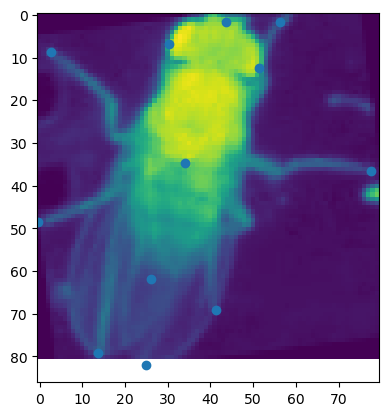

In [91]:
plt.imshow(augmented_image.squeeze(0).permute(1, 2, 0).mean(dim=2))
plt.scatter(
    augmented_keypoints[:, 0],
    augmented_keypoints[:, 1]
)

# Implementing Augmentation Class (using Kornia)

In [96]:
import attr

In [97]:
@attr.s(auto_attribs=True)
class AugmentationConfig:
    """Parameters for configuring an augmentation stack.

    The augmentations will be applied in the the order of the attributes.

    Attributes:
        rotate: If True, rotational augmentation will be applied. Rotation is relative
            to the center of the image. See `imgaug.augmenters.geometric.Affine`.
        rotation_min_angle: Minimum rotation angle in degrees in [-180, 180].
        rotation_max_angle: Maximum rotation angle in degrees in [-180, 180].
        translate: If True, translational augmentation will be applied. The values are
            sampled independently for x and y coordinates. See
            `imgaug.augmenters.geometric.Affine`.
        translate_min: Minimum translation in integer pixel units.
        translate_max: Maximum translation in integer pixel units.
        scale: If True, scaling augmentation will be applied. See
            `imgaug.augmenters.geometric.Affine`.
        scale_min: Minimum scaling factor.
        scale_max: Maximum scaling factor.
        uniform_noise: If True, uniformly distributed noise will be added to the image.
            This is effectively adding a different random value to each pixel to
            simulate shot noise. See `imgaug.augmenters.arithmetic.AddElementwise`.
        uniform_noise_min_val: Minimum value to add.
        uniform_noise_max_val: Maximum value to add.
        gaussian_noise: If True, normally distributed noise will be added to the image.
            This is similar to uniform noise, but can provide a tigher bound around a
            mean noise magnitude. This is applied independently to each pixel.
            See `imgaug.augmenters.arithmetic.AdditiveGaussianNoise`.
        gaussian_noise_mean: Mean of the distribution to sample from.
        gaussian_noise_stddev: Standard deviation of the distribution to sample from.
        contrast: If True, gamma constrast adjustment will be applied to the image.
            This scales all pixel values by `x ** gamma` where `x` is the pixel value in
            the [0, 1] range. Values in [0, 255] are first scaled to [0, 1]. See
            `imgaug.augmenters.contrast.GammaContrast`.
        contrast_min_gamma: Minimum gamma to use for augmentation. Reasonable values are
            in [0.5, 2.0].
        contrast_max_gamma: Maximum gamma to use for augmentation. Reasonable values are
            in [0.5, 2.0].
        brightness: If True, the image brightness will be augmented. This adjustment
            simply adds the same value to all pixels in the image to simulate broadfield
            illumination change. See `imgaug.augmenters.arithmetic.Add`.
        brightness_min_val: Minimum value to add to all pixels.
        brightness_max_val: Maximum value to add to all pixels.
        random_crop: If `True`, performs random crops on the image. This is useful for
            training efficiently on large resolution images, but may fail to learn
            global structure beyond the crop size. Random cropping will be applied after
            the augmentations above.
        random_crop_width: Width of random crops.
        random_crop_height: Height of random crops.
        random_flip: If `True`, images will be randomly reflected. The coordinates of
            the instances will be adjusted accordingly. Body parts that are left/right
            symmetric must be marked on the skeleton in order to be swapped correctly.
        flip_horizontal: If `True`, flip images left/right when randomly reflecting
            them. If `False`, flipping is down up/down instead.
    """

    rotate: bool = False
    rotation_min_angle: float = -180
    rotation_max_angle: float = 180
    translate: bool = False
    # translate_min: int = -5
    # translate_max: int = 5
    translate_pct: float = 0.05
    scale: bool = False
    scale_min: float = 0.9
    scale_max: float = 1.1
    uniform_noise: bool = False
    uniform_noise_min_val: float = 0.0
    uniform_noise_max_val: float = 10.0
    gaussian_noise: bool = False
    gaussian_noise_mean: float = 5.0
    gaussian_noise_stddev: float = 1.0
    contrast: bool = False
    contrast_min_gamma: float = 0.5
    contrast_max_gamma: float = 2.0
    brightness: bool = False
    brightness_min_val: float = 0.0
    brightness_max_val: float = 10.0
    random_crop: bool = False
    random_crop_height: int = 256
    random_crop_width: int = 256
    random_flip: bool = False
    flip_horizontal: bool = True

In [ ]:
from typing import Text
import torchdata.datapipes as dp
import kornia as K

@attr.s(auto_attribs=True)
class KorniaAugmenter:
    """Data transformer based on the `kornia` library.

    This class can generate a `torchdata.datapipes.map.MapDataPipe` from an existing one that generates
    image and instance data. Element of the output dataset will have a set of
    augmentation transformations applied.

    Attributes:
        augmenter: An instance of `kornia.augmentation.container.AugmentationSequential` that will be applied to
            each element of the input dataset.
        image_key: Name of the example key where the image is stored. Defaults to
            "image".
        instances_key: Name of the example key where the instance points are stored.
            Defaults to "instances".
    """

    augmenter: AugmentationSequential
    image_key: str = "image"
    instances_key: str = "instances"

    @classmethod
    def from_config(
        cls,
        config: AugmentationConfig,
        image_key: Text = "image",
        instances_key: Text = "instances",
    ) -> "KorniaAugmenter":
        """Create an augmenter from a set of configuration parameters.

        Args:
            config: An `AugmentationConfig` instance with the desired parameters.
            image_key: Name of the example key where the image is stored. Defaults to
                "image".
            instances_key: Name of the example key where the instance points are stored.
                Defaults to "instances".

        Returns:
            An instance of `KorniaAugmenter` with the specified augmentation
            configuration.
        """
        aug_stack = []
        if config.rotate:
            aug_stack.append(
                K.augmentation.RandomAffine(
                    degrees=(config.rotation_min_angle, config.rotation_max_angle),
                    p=1.0
                )
            )
        if config.translate:
            aug_stack.append(
                K.augmentation.RandomAffine(  # Translate by pct w.r.t. img.
                    degrees=0,
                    translate=(0.05, 0.05),
                    p=1.0
                )
            )
        if config.scale:
            aug_stack.append(
                K.augmentation.RandomAffine(
                    degrees=0,
                    scale=(config.scale_min, config.scale_max),
                    p=1.0
                )
            )
        if config.uniform_noise:
            aug_stack.append(
                RandomUniformNoise(
                    min_val=config.uniform_noise_min_val,
                    max_val=config.uniform_noise_max_val,
                    p=1.0
                )
            )
        if config.gaussian_noise:
            aug_stack.append(
                K.augmentation.RandomGaussianNoise(
                    mean=config.gaussian_noise_mean, std=config.gaussian_noise_stddev
                )
            )
        if config.contrast:
            aug_stack.append(
                K.augmentation.RandomContrast(
                    contrast=(config.contrast_min_gamma, config.contrast_max_gamma),
                    p=1.0
                )
            )
        if config.brightness:
            aug_stack.append(
                K.augmentation.RandomBrightness(
                    brightness=(config.brightness_min_val, config.brightness_max_val),
                    p=1.0
                )
            )

    @property
    def input_keys(self) -> List[Text]:
        """Return the keys that incoming elements are expected to have."""
        return [self.image_key, self.instances_key]

    @property
    def output_keys(self) -> List[Text]:
        """Return the keys that outgoing elements will have."""
        return self.input_keys
    
    def transform_dataset(self, input_ds: dp.map.MapDataPipe) -> dp.map.MapDataPipe:
        pass

In [7]:
import torch
from typing import Dict, Tuple
import kornia as K

class RandomTranslation(K.augmentation.GeometricAugmentationBase2D):
    def __init__(
            self, 
            translate_px : Dict[str, Tuple[int, int]],
            p: float = 0.5, 
            p_batch: float = 1.0, 
            same_on_batch: bool = False, 
            keepdim: bool = False,
        ) -> None:
        super().__init__(p, p_batch, same_on_batch, keepdim)
        self.x_translation = torch.tensor(translate_px["x"], dtype=torch.float32)
        self.y_translation = torch.tensor(translate_px["y"], dtype=torch.float32)

    def compute_transformation(self, input, params, flags):
        # Compute the random translation for each image in the batch.
        batch_size = input.shape[0]
        translations = torch.empty((batch_size, 2), dtype=torch.float32)
        translations[:, 0] = torch.rand(batch_size) * (self.x_translation[1] - self.x_translation[0]) + self.x_translation[0]
        translations[:, 1] = torch.rand(batch_size) * (self.y_translation[1] - self.y_translation[0]) + self.y_translation[0]

        # Create the translation matrix for each image.
        trans_matrix = torch.eye(3, dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1)
        trans_matrix[:, 0, 2] = translations[:, 0]
        trans_matrix[:, 1, 2] = translations[:, 1]

        return trans_matrix

    def apply_transform(self, input, params, flags, transform=None):
        # Apply the translation to the input image.
        return K.geometry.transform.warp_affine(input, transform[:, :2, :], dsize=input.shape[-2:])

In [8]:
from providers import LabelsReader

provider = LabelsReader.from_filename("./labels.slp")
x = next(iter(provider))[1]
x.shape

torch.Size([1024, 1024, 1])

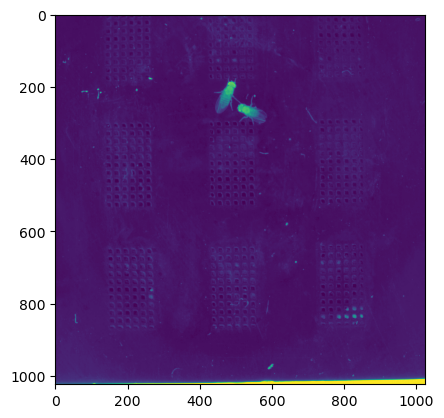

In [9]:
from matplotlib import pyplot as plt

plt.imshow(x)

In [10]:
# Create an instance of RandomTranslation with desired min and max translation values
custom_translation = RandomTranslation(translate_px={"x": (-5, 5), "y": (-5, 5)})

# Generate a random image (shape: [batch_size, channels, height, width])
image = torch.randn(4, 3, 256, 256)

# Apply the custom translation to the image
transformed_image = custom_translation(image)


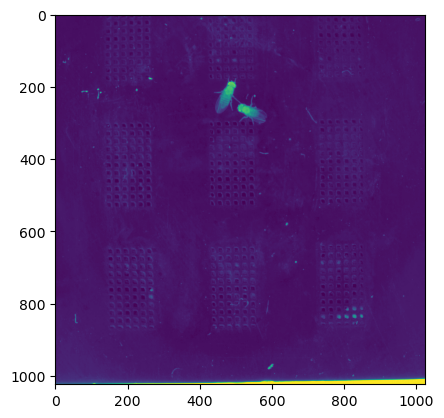

In [11]:
plt.imshow(custom_translation(x/255.0)[0])

In [15]:
import torch
from kornia.core import Tensor, as_tensor, tensor

In [18]:
device = "cpu"
dtype = torch.get_default_dtype()
name = "translate_x"
center = 0.0
bounds = (-1, 1)
factor = (-0.5, 0.5)

if not isinstance(factor, (Tensor)):
    factor = tensor(factor, device=device, dtype=dtype)
factor_bound: Tensor

if factor.dim() == 0:
    if factor < 0:
        raise ValueError(f"If {name} is a single number, it must be non negative. Got {factor}.")
    if center is None or bounds is None:
        raise ValueError(f"`center` and `bounds` cannot be None for single number. Got {center}, {bounds}.")
    # Should be something other than clamp
    # Currently, single value factor will not out of scope as long as the user provided it.
    # Note: I personally think throw an error will be better than a coarse clamp.
    factor_bound = factor.repeat(2) * tensor([-1.0, 1.0], device=factor.device, dtype=factor.dtype) + center
    factor_bound = factor_bound.clamp(bounds[0], bounds[1]).to(device=device, dtype=dtype)
else:
    factor_bound = as_tensor(factor, device=device, dtype=dtype)

In [22]:
from kornia.augmentation.utils.param_validation import _joint_range_check, _singular_range_check

check = "joint"

if check is not None:
    if check == 'joint':
        _joint_range_check(factor_bound, name, bounds)
    elif check == 'singular':
        _singular_range_check(factor_bound, name, bounds)
    else:
        raise NotImplementedError(f"methods '{check}' not implemented.")

In [23]:
from torch.distributions import Uniform

In [25]:
factor_bound[..., 0]

tensor(-0.5000)

In [28]:
factor

tensor([-0.5000,  0.5000])

In [57]:
batch_size = 1
same_on_batch = False
_dtype = torch.get_default_dtype()
_device = "cpu"
translate_x_sampler = Uniform(factor_bound[..., 0], factor_bound[..., 1])
width = 1024
from kornia.augmentation.utils import _adapted_rsampling


translate_x = (
    _adapted_rsampling((batch_size,), translate_x_sampler, same_on_batch).to(
        device=_device, dtype=_dtype
    )
    * width
)
translate_x

tensor([251.0192])

In [61]:
from kornia.core import Tensor, as_tensor, stack


translations = stack([translate_x, translate_x + 2], dim=-1)


In [62]:
translations

tensor([[251.0192, 253.0192]])

In [63]:
a = Uniform(factor_bound[..., 0], factor_bound[..., 1])
a

Uniform(low: -0.5, high: 0.5)

In [64]:
from kornia.geometry.transform import get_translation_matrix2d

b = get_translation_matrix2d(as_tensor(translations, device=_device, dtype=_dtype))
b.shape

torch.Size([1, 3, 3])

In [65]:
b[:, :2, :]

tensor([[[  1.0000,   0.0000, 251.0192],
         [  0.0000,   1.0000, 253.0192]]])

In [66]:
b[:, :2, :].shape

torch.Size([1, 2, 3])

In [116]:
import attr
from typing import Tuple, Dict, Any, Optional, Union
import torch
import torchdata.datapipes as dp
import kornia as K
from kornia.augmentation._2d.geometric.base import GeometricAugmentationBase2D
from kornia.augmentation._2d.intensity.base import IntensityAugmentationBase2D
from kornia.core import Tensor
from kornia.constants import Resample, SamplePadding
from kornia.geometry.transform import warp_affine

class RandomTranslationPx(GeometricAugmentationBase2D):
    def __init__(
        self,
        translate_px: Dict[str, Tuple[int, int]],
        resample: Union[str, int, Resample] = Resample.BILINEAR.name,
        same_on_batch: bool = False,
        align_corners: bool = False,
        padding_mode: Union[str, int, SamplePadding] = SamplePadding.ZEROS.name,
        p: float = 0.5,
        keepdim: bool = False,
    ):
        super().__init__(p=p, same_on_batch=same_on_batch, keepdim=keepdim)
        self.translate_px = translate_px
        self.flags = {
            "resample": Resample.get(resample),
            "padding_mode": SamplePadding.get(padding_mode),
            "align_corners": align_corners,
        }

    def compute_transformation(self, input: Tensor, params: Dict[str, Tensor], flags: Dict[str, Any]) -> Tensor:
        batch_size = input.shape[0]
        translations = torch.empty((batch_size, 2), dtype=torch.float32)
        translations[:, 0] = (
            torch.rand(batch_size) * (self.translate_px["x"][1] - self.translate_px["x"][0])
            + self.translate_px["x"][0]
        )
        translations[:, 1] = (
            torch.rand(batch_size) * (self.translate_px["y"][1] - self.translate_px["y"][0])
            + self.translate_px["y"][0]
        )

        print(translations)
        
        trans_matrix = (
            torch.eye(3, dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1)
        )
        trans_matrix[:, 0, 2] = translations[:, 0]
        trans_matrix[:, 1, 2] = translations[:, 1]

        return trans_matrix

    def apply_transform(
        self, input: Tensor, params: Dict[str, Tensor], flags: Dict[str, Any], transform: Optional[Tensor] = None
    ) -> Tensor:
        if "translate_px" in params:
            tfm_matrix = params["translate_px"]
        else:
            tfm_matrix = transform[:, :2, :].to(input.device)
            self._params["translate_px"] = tfm_matrix
        return warp_affine(input, tfm_matrix, dsize=input.shape[-2:])

In [117]:
from providers import LabelsReader
import sleap_io as sio
import kornia as K

augs = K.augmentation.AugmentationSequential(
    RandomTranslationPx(
        translate_px={
            "x": (-5, 5), 
            "y": (-5, 5)
        },
        p=1.0
    ),
    data_keys=["input", "keypoints"]
)

l = sio.load_slp("labels.slp")
provider = LabelsReader(l)
x = next(iter(provider))

img = K.color.grayscale_to_rgb(torch.Tensor(x[1]).permute(2, 0, 1))/255.0
kp = torch.Tensor(x[0]).float()
aug_img, aug_kp = augs(img, kp)

tensor([[-1.0789, -1.3236]])


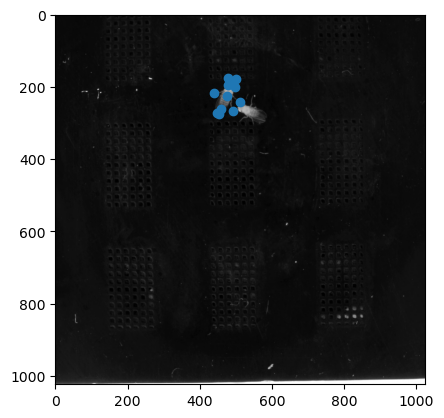

In [110]:
plt.imshow(img.permute(1, 2, 0))
plt.scatter(kp[:, 0], kp[:, 1])

In [115]:
aug_kp, kp

(tensor([[491.2413, 188.0095],
         [474.0205, 225.0907],
         [459.5611, 262.4511],
         [447.9215, 272.0096],
         [451.7413, 273.8293],
         [478.1601, 176.1897],
         [499.6017, 178.1897],
         [440.2413, 216.6491],
         [509.7819, 243.0095],
         [     nan,      nan],
         [490.5611, 267.0096],
         [477.2007, 193.4511],
         [498.0611, 201.4689]]),
 tensor([[491.5812, 187.7208],
         [474.3604, 224.8020],
         [459.9010, 262.1624],
         [448.2614, 271.7208],
         [452.0812, 273.5406],
         [478.5000, 175.9010],
         [499.9416, 177.9010],
         [440.5812, 216.3604],
         [510.1218, 242.7208],
         [     nan,      nan],
         [490.9010, 266.7208],
         [477.5406, 193.1624],
         [498.4010, 201.1802]]))

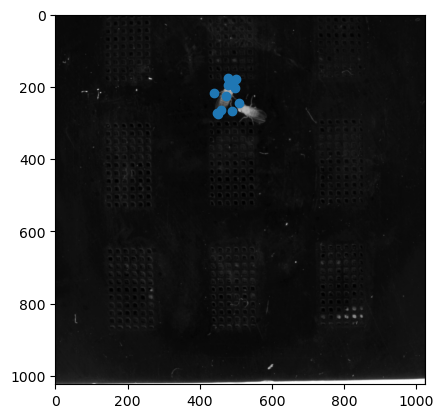

In [114]:
plt.imshow(aug_img[0].permute(1, 2, 0))
plt.scatter(aug_kp[:, 0], aug_kp[:, 1])

# Testing Provider

In [1]:
from providers import LabelsReader

In [2]:
provider = LabelsReader.from_filename("./labels.slp")

In [ ]:
pipe = [provider]
pipe += KorniaAugmenter.from_config()

In [4]:
a = next(iter(reader))

In [5]:
len(a)

2

In [6]:
a[0]

tensor([[491.5812, 187.7208],
        [474.3604, 224.8020],
        [459.9010, 262.1624],
        [448.2614, 271.7208],
        [452.0812, 273.5406],
        [478.5000, 175.9010],
        [499.9416, 177.9010],
        [440.5812, 216.3604],
        [510.1218, 242.7208],
        [     nan,      nan],
        [490.9010, 266.7208],
        [477.5406, 193.1624],
        [498.4010, 201.1802]], dtype=torch.float64)

In [9]:
a[0].shape, a[1].shape

(torch.Size([13, 2]), torch.Size([1024, 1024, 1]))

In [10]:
type(reader)

providers.LabelsReader

In [23]:
# Create a sample data list
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [35]:
import attr

# First IterDataPipe to process data
class PreprocessData(dp.IterDataPipe):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __iter__(self):
        for item in self.data:
            processed_item = item * 2  # Perform some preprocessing operation
            yield processed_item

    def __len__(self):
        return len(self.data)

# Second IterDataPipe to filter data
@attr.s(auto_attribs=True)
class FilterData(dp.IterDataPipe):
    data_pipe: dp.IterDataPipe

    def __iter__(self):
        for item in self.data_pipe:
            print("filterdata", item)
            if item % 3 == 0:  # Filter out items that are not divisible by 3
                yield item

    @classmethod
    def from_config(cls, data_pipe: dp.IterDataPipe) -> "FilterData":
        return cls(data_pipe)

    def __len__(self):
        return len(self.data_pipe)

# Create a sample data list
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Chain the IterDataPipe objects
preprocessed_data_pipe = PreprocessData(data)
filtered_data_pipe = FilterData(preprocessed_data_pipe)

pipe = [preprocessed_data_pipe]
pipe += FilterData.from_config(pipe[0])

# Iterate over the filtered data pipe
for item in filtered_data_pipe:
    print(item)


filterdata 2
filterdata 4
filterdata 6
filterdata 8
filterdata 10
filterdata 12
filterdata 14
filterdata 16
filterdata 18
filterdata 20
filterdata 2
filterdata 4
filterdata 6
6
filterdata 8
filterdata 10
filterdata 12
12
filterdata 14
filterdata 16
filterdata 18
18
filterdata 20


In [ ]:
def build_dummy_pipeline(provider):
